In [1]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [2]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

In [3]:
for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/64x64/train_normal/*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/64x64/train_attack/*.jpg', recursive=True):
    train_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/64x64/test_normal/*.jpg', recursive=True):
    test_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/64x64/test_attack/*.jpg', recursive=True):
    test_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

train_normal = np.stack(train_normal)
train_attack = np.stack(train_attack)
test_normal = np.stack(test_normal)
test_attack = np.stack(test_attack)

In [4]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack),

((1874, 64, 64), (1628, 64, 64), (271, 64, 64), (357, 64, 64))

In [5]:
## augmenting the data to create more images

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))

In [6]:
train = np.vstack((train_normal, train_attack, vert_flip_train_attack, vert_flip_train_normal, hor_flip_train_attack, hor_flip_train_normal,rotate90l_train_attack, rotate90r_train_attack, rotate90r_train_normal, rotate90l_train_normal))

test = np.vstack((test_normal, test_attack, vert_flip_test_attack, vert_flip_test_normal, hor_flip_test_attack, hor_flip_test_normal,rotate90l_test_attack, rotate90r_test_attack, rotate90l_test_normal, rotate90r_test_normal))

In [7]:
train.shape, test.shape

((17510, 64, 64), (3140, 64, 64))

In [8]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

In [9]:
train.shape, test.shape

((17510, 64, 64, 1), (3140, 64, 64, 1))

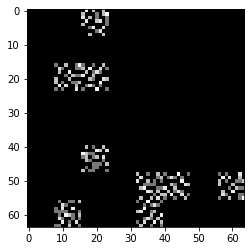

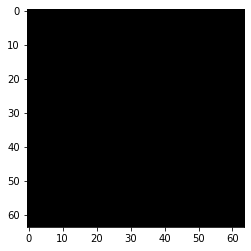

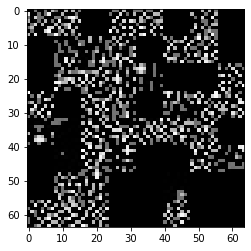

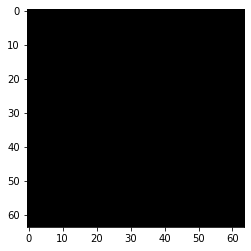

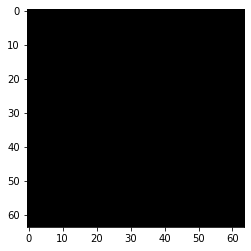

In [10]:
for i in range(0, 5):
    plt.imshow(train[i], cmap = 'gray')
    plt.show()

In [45]:
## create the training and testing data labels

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [46]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 17505       0       1
 17506       0       1
 17507       0       1
 17508       0       1
 17509       0       1
 
 [17510 rows x 2 columns],
       attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 3135       0       1
 3136       0       1
 3137       0       1
 3138       0       1
 3139       0       1
 
 [3140 rows x 2 columns])

In [47]:
## shuffle the data to prevent pattern recognition
train = sklearn.utils.shuffle(train, random_state = 7)
ytrain = sklearn.utils.shuffle(ytrain, random_state = 7)

test = sklearn.utils.shuffle(test, random_state = 7)
ytest = sklearn.utils.shuffle(ytest, random_state = 7)

In [48]:
cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (64,64,1)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 2
cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 4
cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.8))

## convolution 6
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (1,1)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
average_pooling2d_4 (Average (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
average_pooling2d_5 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
average_pooling2d_6 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [49]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 256, epochs = 200)
end = time.time()

os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/200
69/69 [==============================] - 11s 151ms/step - loss: 0.8853 - accuracy: 0.5379
Epoch 2/200
69/69 [==============================] - 10s 151ms/step - loss: 0.6444 - accuracy: 0.6177
Epoch 3/200
69/69 [==============================] - 10s 151ms/step - loss: 0.5882 - accuracy: 0.6680
Epoch 4/200
69/69 [==============================] - 10s 151ms/step - loss: 0.5762 - accuracy: 0.6723
Epoch 5/200
69/69 [==============================] - 10s 152ms/step - loss: 0.5130 - accuracy: 0.7160
Epoch 6/200
69/69 [==============================] - 10s 151ms/step - loss: 0.5609 - accuracy: 0.6781
Epoch 7/200
69/69 [==============================] - 10s 151ms/step - loss: 0.5014 - accuracy: 0.7278
Epoch 8/200
69/69 [==============================] - 10s 152ms/step - loss: 0.4985 - accuracy: 0.7268
Epoch 9/200
69/69 [==============================] - 10s 151ms/step - loss: 0.5864 - accuracy: 0.6478
Epoch 10/200
69/69 [==============================] - 11s 152ms/step - loss: 0.504

TypeError: unsupported operand type(s) for +: 'float' and 'str'

dict_keys(['loss', 'accuracy'])


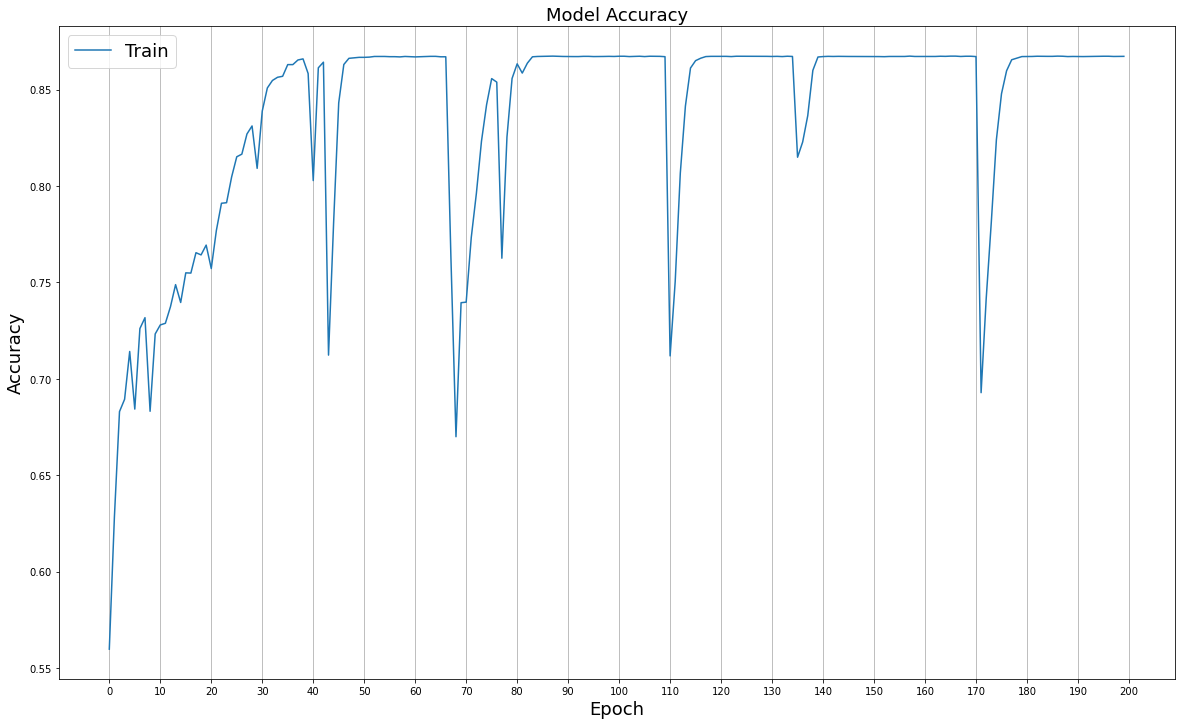

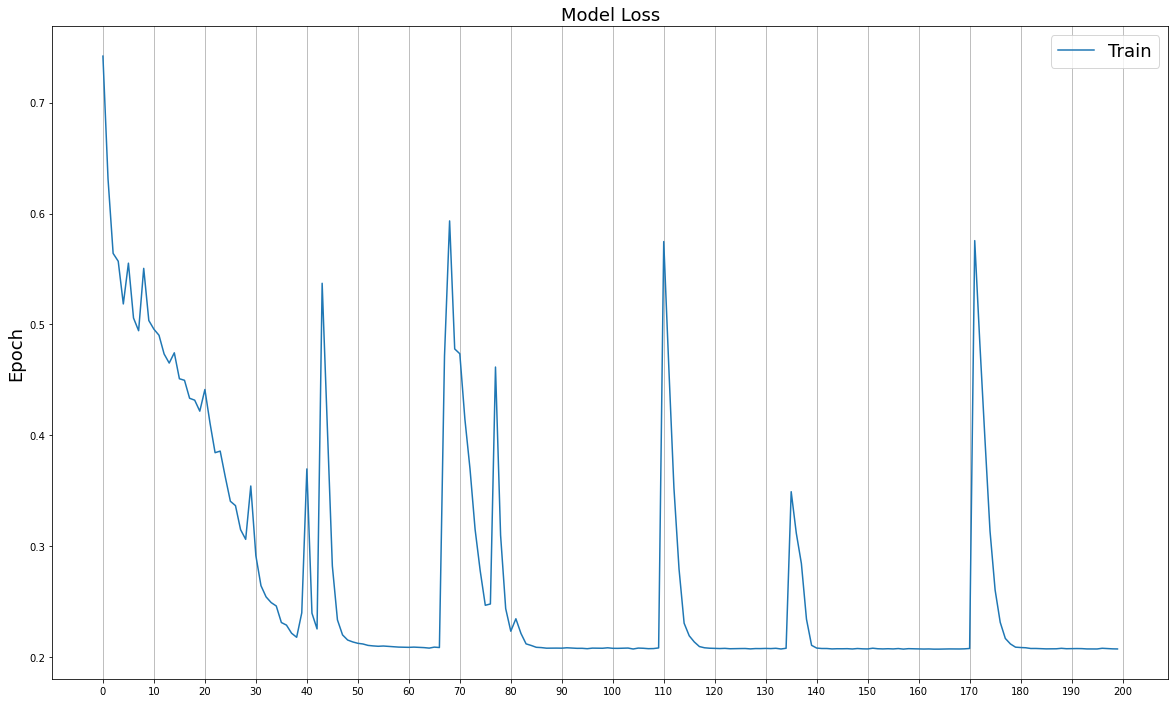

In [50]:
print(model_history.history.keys())

figure(figsize = (20,12))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

figure(figsize = (20,12))
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

In [51]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 200, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.5626	Accuracy = 72.00999999999999%


In [52]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.00082, 0.99935],
       [0.99998, 0.00002],
       [0.     , 1.     ],
       [0.84439, 0.16952],
       [1.     , 0.     ],
       [0.45343, 0.5465 ],
       [0.99993, 0.00009],
       [0.1921 , 0.79536],
       [0.     , 1.     ],
       [0.     , 1.     ],
       [0.     , 1.     ],
       [0.62215, 0.35425],
       [0.99996, 0.00002],
       [0.0355 , 0.95939],
       [0.99912, 0.00053],
       [1.     , 0.     ],
       [1.     , 0.     ],
       [0.     , 1.     ],
       [0.45343, 0.5465 ],
       [0.04706, 0.88531]], dtype=float32)

In [53]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (64,64,1)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(256, (3,3), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 6
    # cnn.add(Convolution2D(512, (2,2), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (1,1)))
    # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(256, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 256, epochs = 200)

In [54]:
scores = cross_val_score(estimator = classifier, X = test, y = ytest, cv = 10, n_jobs = -1)
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{scores}')

os.system('say "cross validation finished" ')

Model Cross Validation: 
77.0%
Model Cross Validation: 
[0.82484 0.82484 0.76115 0.76433 0.7707  0.7707  0.80573 0.71019 0.73567
 0.73567]


0